2015 - March 2024 -> test: march - june 2024
try models: arima + lstm + xgboost + tiny time mixer

In [84]:
import yfinance as yf
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import torch
from keras.api.models import Sequential
from keras.api.layers import LSTM, Dense

In [53]:
ticker = 'AAPL'
data_train = yf.download(ticker, start='2015-01-01', end='2024-03-01')
data_test = yf.download(ticker, start='2024-03-01', end='2024-06-30')
full_data = pd.concat([data_train, data_test]).reset_index()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [54]:
# data_train.to_csv(rf'C:\Users\MY PC\Project\data\{ticker}_stock_train.csv')
# data_test.to_csv(rf'C:\Users\MY PC\Project\data\{ticker}_stock_test.csv')
# full_data.to_csv(rf'C:\Users\MY PC\Project\data\{ticker}_stock.csv')

In [55]:
min_time = pd.to_datetime("2015-01-01").strftime('%Y-%m-%d')
max_time = pd.to_datetime(full_data["Date"]).max().strftime('%Y-%m-%d')
print(min_time)
print(max_time)

2015-01-01
2024-06-28


In [56]:
len(data_train)

2305

In [57]:
len(data_test)

83

In [58]:
full_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.373960,212818400
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.687305,257142000
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.689537,263188400
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,24.021713,160423600
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,24.944689,237458000


In [59]:
full_data['Date'] = pd.to_datetime(full_data['Date'])
full_date_range = pd.date_range(start='2015-01-01', end='2024-06-28', freq='D')
full_dates_df = pd.DataFrame(full_date_range, columns=['Date'])

In [60]:
full_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.373960,212818400
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.687305,257142000
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.689537,263188400
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,24.021713,160423600
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,24.944689,237458000


Notes:
- Determine that this is multivariate time series forecasting
- Good models: ARIMA, LSTM, gradient boosting, try out TTMs
- liquid neural network?
- "Close" is the target, used for predictions

### OHLCV graph with plotly

In [61]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
               vertical_spacing=0.1, subplot_titles=('OHLC', 'Volume'), 
               row_width=[0.4, 0.7])

fig.add_trace(go.Ohlc(x=full_data['Date'],
				open=full_data['Open'],
				high=full_data['High'],
				low=full_data['Low'],
				close=full_data['Close'],
				showlegend=False), row=1, col=1)

fig.add_trace(go.Scatter(x=full_data['Date'], 
                         y=full_data['Volume'], 
                         mode='lines',
                         line=dict(color='blue', width=0.7),
						 showlegend=False, 
                         name='Volume'), row=2, col=1)

fig.update_layout(
    autosize=False,
    width=1100,
    height=900,
    title='OHLC and Volume of AAPL stock from January 2015 to June 2024',
    xaxis1_rangeslider_visible=False,
    xaxis2_rangeslider_visible=False,
)

fig.show()

### Check for non-stationarity
- Try the Augmented Dickey Fuller (ADF) test:
	- If p-value > 0.05, then data is not stationary (most stock prices aren't stationary)
- Autocorrelation Function (ACF) plot to resolve this
- Reference: https://www.youtube.com/watch?v=gqryqIlvEoM&ab_channel=DecisionForest

In [83]:
returns = adfuller(full_data["Close"].dropna())
print(f"ADF statistics: {returns[0]}")
print(f"p-value: {returns[1]}")      # p-value > 0.05, so the data is not stationary

ADF statistics: 0.23769101945182308
p-value: 0.9742980823824576


#### Plot ACF

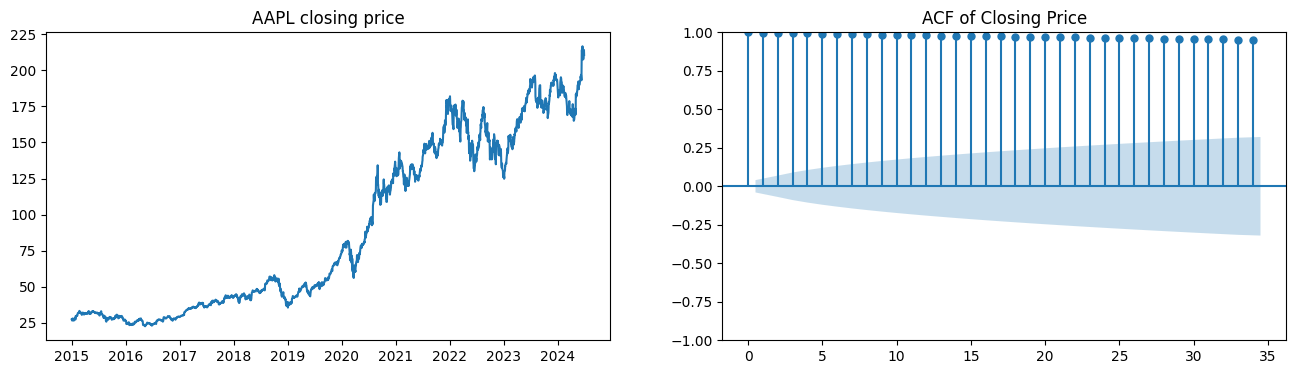

In [92]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(full_data['Date'], full_data['Close'])
ax1.set_title('AAPL closing price')
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plot_acf(full_data['Close'], ax=ax2)
ax2.set_title('ACF of Closing Price')
plt.show()

### Correlation matrix

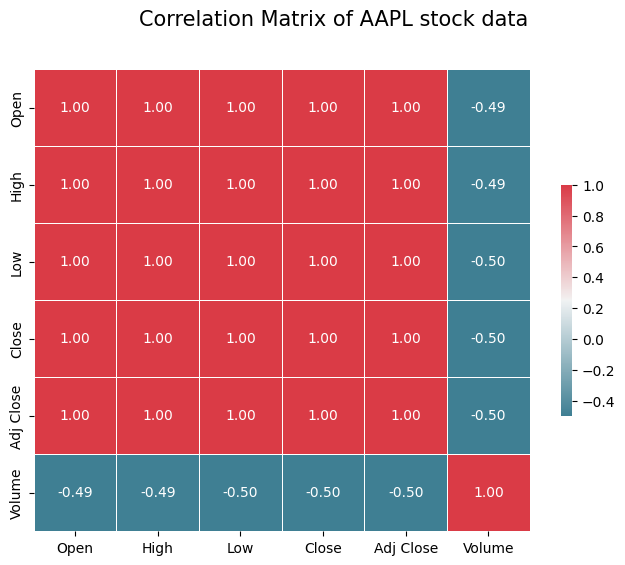

In [71]:
num_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
def correlation_matrix(df, numeric_cols):
    """
    Plot correlation heatmaps of the target variable against all other variables for each category.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    """
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 6))  # Fixed variable name `ax`

    corr = df[numeric_cols].corr()
    
    sns.heatmap(
        corr,
        cmap=sns.diverging_palette(220, 10, as_cmap=True),
        ax=ax,
        annot=True,
        fmt=".2f",
        linewidths=0.5,
        cbar_kws={"shrink": 0.5},
    )
    
    plt.suptitle('Correlation Matrix of AAPL stock data', fontsize=15)
    plt.show()

correlation_matrix(full_data, num_cols)

## Stock prediction with ARIMA

In [62]:
def get_arima_forecasts(df, cat_col, formatted_date, target_col,
                        start_date, end_date, context_len=64):
    """
    Forecast stock value with ARIMA

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    cat_col (str): The column name for categories.
    formatted_date (str): Date column name.
    target_col (str): The target variable to correlate with other variables.
    start_date (str): Lower bound for normal data
    end_date (str): Upper bound for normal data. Normal data is used as training
    resource for ARIMA model
    context_len (int, Default=64): number of points to make prediction on

    Returns: a dictionary containing 'train_data','test_data',
    'forecasts', 'actuals', 'timestamps' (date) and 'forecast_timestamps'

    """

    def get_arma_forecast(context, p=1, r=0, q=0):
        arma = ARIMA(context, order=(p, r, q)).fit(
            method_kwargs={"warn_convergence": False}
        )
        predict_cat = arma.predict(len(context), len(context))
        return predict_cat

    df[formatted_date] = pd.to_datetime(df[formatted_date])
    cats = list(df[cat_col].unique())

    predictions = {}

    # Extract normal data
    normal_data = df[
        (df[formatted_date] >= start_date) & (df[formatted_date] <= end_date)
    ]

    for x in cats:
        sep_df = df[df[cat_col] == x]

        # Prepare data for scaling
        train_data = normal_data[normal_data[cat_col] == x][[target_col]].values

        # Scale the data using the same scaler for training and test data
        scaler = StandardScaler()
        scaled_train_data = scaler.fit_transform(train_data)

        # Prepare test data
        test_data = df[(df[formatted_date] > end_date) & (df[cat_col] == x)][
            [target_col]
        ].values
        scaled_test_data = scaler.transform(test_data)

        forecast_len = 1  # Predicting the next value

        arma_summary = []

        for idx in range(len(scaled_test_data) - context_len - forecast_len + 1):
            context = scaled_test_data[idx : idx + context_len]
            actual = scaled_test_data[
                idx + context_len : idx + context_len + forecast_len
            ]
            forecast = get_arma_forecast(context)
            arma_summary.append((context, actual, forecast))

        # Extract actual and forecast values
        arma_actual = [i[1][0] for i in arma_summary]
        arma_forecast = [i[2][0] for i in arma_summary]

        # Inverse transform the scaled data for evaluation
        inv_train_data = scaler.inverse_transform(scaled_train_data)
        inv_test_data = scaler.inverse_transform(scaled_test_data)
        inv_arma_forecast = scaler.inverse_transform(
            np.array(arma_forecast).reshape(-1, 1)
        )

        predictions[x] = {
            "train_data": inv_train_data,
            "test_data": inv_test_data,
            "forecasts": inv_arma_forecast,
            "actuals": arma_actual,
            "timestamps": sep_df[formatted_date],
            "forecast_timestamps": sep_df[formatted_date][
                len(train_data)
                + context_len : len(train_data)
                + context_len
                + len(arma_forecast)
            ],
            cat_col: x,
        }

        # Calculate and print MSE
        if len(arma_actual) > 0 and len(arma_forecast) > 0:
            actual_array = np.array(arma_actual)
            forecast_array = np.array(arma_forecast)
            mape = np.mean(np.abs(actual_array - forecast_array / actual_array))
            print(f"MSE for {x}: {np.round(mse(arma_actual, arma_forecast), 5)}")
            print(f"MAD for {x}: {sm.robust.scale.mad(arma_forecast)}")
            print(f"MAPE for {x}: {mape * 100:.2f}%")
        else:
            raise ValueError(
                "No forecasts were generated. Check your data and sliding window configuration."
            )

    return pd.DataFrame(predictions)